### **Library Imports**

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

### **Utilities and Constants**

In [2]:
SEED = 42


def breaker(num: int = 50, char: str = "*") -> None:
    print("\n" + num*char + "\n")

    
def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

### **Configuration**

In [3]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 HL: list = [],
                 DP: float = 0.0,
                 use_WN: bool = False,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 patience: int = 5,
                 eps: float = 1e-8
                 ):
        
        self.seed = seed
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.DP = DP
        self.use_WN = use_WN
        self.HL = HL
        
        if len(self.HL) > 3:raise NotImplementedError("Only supports a maximum of 3 hidden layers")
        
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.read_path = "../input/cardiovascular-disease-dataset/cardio_train.csv"
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)

cfg = CFG(seed=SEED)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, features: np.ndarray, labels: np.ndarray=None):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.FloatTensor(self.features[idx]), torch.FloatTensor(self.labels[idx])
        return torch.FloatTensor(self.features[idx])

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self, IL: int, HL: list, DP: float=None, use_WN: bool=False):
        
        super(Model, self).__init__()
        
        self.model = nn.Sequential()
        if len(HL) == 0:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN:
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=1)))
            else:
                self.model.add_module("FC1", nn.Linear(in_features=IL, out_features=1))

        elif len(HL) == 1:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN:
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
            else:
                self.model.add_module("FC1", nn.Linear(in_features=IL, out_features=HL[0]))
            if isinstance(DP, float):
                self.model.add_module("DP1", nn.Dropout(p=DP))
            self.model.add_module("AN1", nn.ReLU())
            self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
            if use_WN:
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=1)))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=HL[0], out_features=1))

        elif len(HL) == 2:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN:
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
            else:
                self.model.add_module("FC1", nn.Linear(in_features=IL, out_features=HL[0]))
            if isinstance(DP, float):
                self.model.add_module("DP1", nn.Dropout(p=DP))
            self.model.add_module("AN1", nn.ReLU())
            self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
            if use_WN:
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=HL[0], out_features=HL[1]))
            if isinstance(DP, float):
                self.model.add_module("DP2", nn.Dropout(p=DP))
            self.model.add_module("AN2", nn.ReLU())
            self.model.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
            if use_WN:
                self.model.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=1)))
            else:
                self.model.add_module("FC3", nn.Linear(in_features=HL[1], out_features=1))
                
        elif len(HL) == 3:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN:
                self.model.add_module("FC2", WN(nn.Linear(in_features=IL, out_features=HL[0])))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=IL, out_features=HL[0]))
            if isinstance(DP, float):
                self.model.add_module("DP1", nn.Dropout(p=DP))
            self.model.add_module("AN1", nn.ReLU())
            self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
            if use_WN:
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=HL[0], out_features=HL[1]))
            if isinstance(DP, float):
                self.model.add_module("DP2", nn.Dropout(p=DP))
            self.model.add_module("AN2", nn.ReLU())
            self.model.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
            if use_WN:
                self.model.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=HL[2])))
            else:
                self.model.add_module("FC3", nn.Linear(in_features=HL[1], out_features=HL[2]))
            if isinstance(DP, float):
                self.model.add_module("DP3", nn.Dropout(p=DP))
            self.model.add_module("AN3", nn.ReLU())
            self.model.add_module("BN4", nn.BatchNorm1d(num_features=HL[2], eps=1e-5))
            if use_WN:
                self.model.add_module("FC4", WN(nn.Linear(in_features=HL[2], out_features=1)))
            else:
                self.model.add_module("FC4", nn.Linear(in_features=HL[2], out_features=1))

    def forward(self, x):
        return self.model(x)

### **Fit and Predict Helper**

In [6]:
def fit(model=None, 
        optimizer=None,
        scheduler_rlrop=None,
        scheduler_oclr=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None, 
        device=None,
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0
        
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, LRs, Accuracies = [], [], []
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"
        
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.BCEWithLogitsLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        if scheduler_oclr: LRs.append(scheduler.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict"     : model.state_dict(),
                            "optim_state_dict"     : optimizer.state_dict()},
                           os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict"     : model.state_dict(),
                        "optim_state_dict"     : optimizer.state_dict()},
                        os.path.join(save_path, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], epochAccs["train"], epochAccs["valid"], time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, name


def predict(model=None, dataloader=None, path=None, device=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(device)
    
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.sigmoid(model(X))
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred[1:].detach().cpu().numpy()

### **Train**


**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.58594 | Valid Loss: 0.57482 | Train Accs: 0.70354 | Valid Accs: 0.73193 | Time: 9.82 seconds
Epoch: 2 | Train Loss: 0.57746 | Valid Loss: 0.57575 | Train Accs: 0.71066 | Valid Accs: 0.72879 | Time: 9.80 seconds
Epoch: 3 | Train Loss: 0.57529 | Valid Loss: 0.57303 | Train Accs: 0.71154 | Valid Accs: 0.73129 | Time: 9.49 seconds
Epoch: 4 | Train Loss: 0.57410 | Valid Loss: 0.57606 | Train Accs: 0.71237 | Valid Accs: 0.73229 | Time: 9.36 seconds
Epoch: 5 | Train Loss: 0.57469 | Valid Loss: 0.60165 | Train Accs: 0.71262 | Valid Accs: 0.71150 | Time: 9.53 seconds
Epoch: 6 | Train Loss: 0.57388 | Valid Loss: 0.57423 | Train Accs: 0.71500 | Valid Accs: 0.72407 | Time: 9.62 seconds
Epoch: 7 | Train Loss: 0.57356 | Valid Loss: 0.57082 | Train Accs: 0.71289 | Valid Accs: 0.73207 | Time: 9.28 seconds
Epoch: 8 | Train Loss: 0.57207 | Valid Loss: 0.60

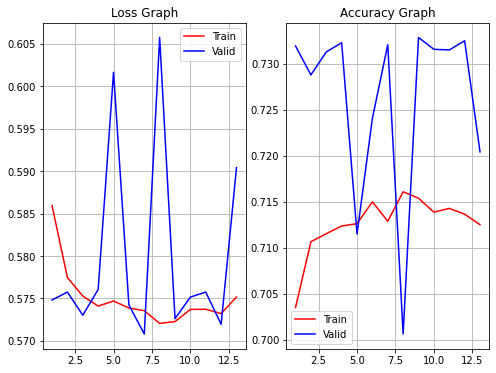


**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.62453 | Valid Loss: 0.60480 | Train Accs: 0.65526 | Valid Accs: 0.68034 | Time: 1.73 seconds
Epoch: 2 | Train Loss: 0.59326 | Valid Loss: 0.61844 | Train Accs: 0.69828 | Valid Accs: 0.65922 | Time: 1.89 seconds
Epoch: 3 | Train Loss: 0.58580 | Valid Loss: 0.61852 | Train Accs: 0.70853 | Valid Accs: 0.66267 | Time: 1.78 seconds
Epoch: 4 | Train Loss: 0.57903 | Valid Loss: 0.60559 | Train Accs: 0.71158 | Valid Accs: 0.68705 | Time: 1.83 seconds
Epoch: 5 | Train Loss: 0.57823 | Valid Loss: 0.61404 | Train Accs: 0.71647 | Valid Accs: 0.67298 | Time: 1.89 seconds
Epoch: 6 | Train Loss: 0.57498 | Valid Loss: 0.61185 | Train Accs: 0.71707 | Valid Accs: 0.67883 | Time: 1.71 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Be

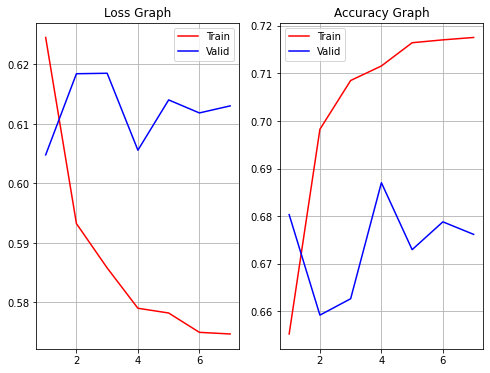


**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.62208 | Valid Loss: 0.62509 | Train Accs: 0.66072 | Valid Accs: 0.65670 | Time: 1.72 seconds
Epoch: 2 | Train Loss: 0.59003 | Valid Loss: 0.61689 | Train Accs: 0.69970 | Valid Accs: 0.67469 | Time: 2.25 seconds
Epoch: 3 | Train Loss: 0.58110 | Valid Loss: 0.62145 | Train Accs: 0.71046 | Valid Accs: 0.66821 | Time: 1.72 seconds
Epoch: 4 | Train Loss: 0.57614 | Valid Loss: 0.60166 | Train Accs: 0.71531 | Valid Accs: 0.70797 | Time: 1.73 seconds
Epoch: 5 | Train Loss: 0.57380 | Valid Loss: 0.62041 | Train Accs: 0.71900 | Valid Accs: 0.66877 | Time: 1.86 seconds
Epoch: 6 | Train Loss: 0.57304 | Valid Loss: 0.61256 | Train Accs: 0.71821 | Valid Accs: 0.68891 | Time: 1.73 seconds
Epoch: 7 | Train Loss: 0.57293 | Valid Loss: 0.61170 | Train Accs: 0.71892 | Valid Accs: 0.69685 | Time: 1.85 seconds
Epoch: 8 | Train Loss: 0.57153 | Valid Loss: 0.61

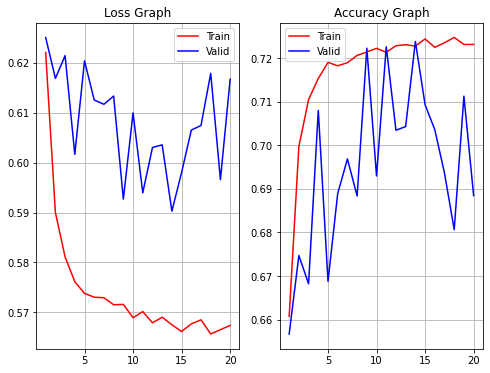


**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.62108 | Valid Loss: 0.61426 | Train Accs: 0.66090 | Valid Accs: 0.67073 | Time: 1.87 seconds
Epoch: 2 | Train Loss: 0.58999 | Valid Loss: 0.60688 | Train Accs: 0.69854 | Valid Accs: 0.68179 | Time: 1.76 seconds
Epoch: 3 | Train Loss: 0.58143 | Valid Loss: 0.62024 | Train Accs: 0.70916 | Valid Accs: 0.66458 | Time: 1.70 seconds
Epoch: 4 | Train Loss: 0.57743 | Valid Loss: 0.61119 | Train Accs: 0.71295 | Valid Accs: 0.68132 | Time: 1.86 seconds
Epoch: 5 | Train Loss: 0.57573 | Valid Loss: 0.60285 | Train Accs: 0.71655 | Valid Accs: 0.69018 | Time: 1.83 seconds
Epoch: 6 | Train Loss: 0.57485 | Valid Loss: 0.61625 | Train Accs: 0.71707 | Valid Accs: 0.67127 | Time: 1.98 seconds
Epoch: 7 | Train Loss: 0.57332 | Valid Loss: 0.59195 | Train Accs: 0.71723 | Valid Accs: 0.70543 | Time: 1.77 seconds
Epoch: 8 | Train Loss: 0.57142 | Valid Loss: 0.58

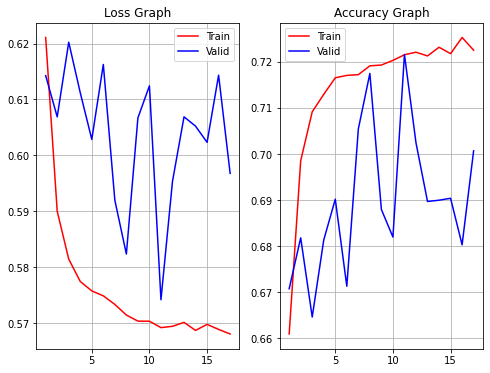


**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.62167 | Valid Loss: 0.61814 | Train Accs: 0.66008 | Valid Accs: 0.67714 | Time: 1.92 seconds
Epoch: 2 | Train Loss: 0.59082 | Valid Loss: 0.62523 | Train Accs: 0.69854 | Valid Accs: 0.66012 | Time: 1.74 seconds
Epoch: 3 | Train Loss: 0.58054 | Valid Loss: 0.61891 | Train Accs: 0.71122 | Valid Accs: 0.67553 | Time: 1.71 seconds
Epoch: 4 | Train Loss: 0.57937 | Valid Loss: 0.61999 | Train Accs: 0.71200 | Valid Accs: 0.67529 | Time: 1.86 seconds
Epoch: 5 | Train Loss: 0.57558 | Valid Loss: 0.61772 | Train Accs: 0.71653 | Valid Accs: 0.67912 | Time: 1.70 seconds
Epoch: 6 | Train Loss: 0.57310 | Valid Loss: 0.62130 | Train Accs: 0.71763 | Valid Accs: 0.67388 | Time: 1.85 seconds
Epoch: 7 | Train Loss: 0.57212 | Valid Loss: 0.62077 | Train Accs: 0.71931 | Valid Accs: 0.67255 | Time: 1.77 seconds
Epoch: 8 | Train Loss: 0.57082 | Valid Loss: 0.59

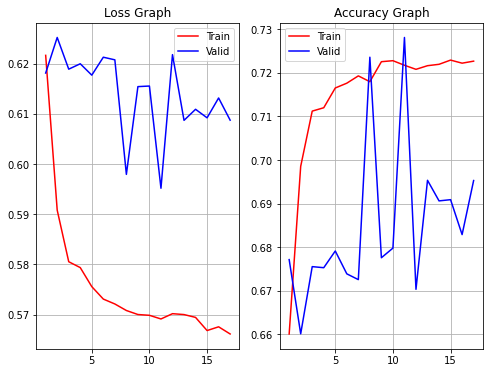

In [7]:
fold = 1
BLEs, BAEs = [], []


df = pd.read_csv(cfg.read_path, delimiter=";")
df = df.drop(columns=["id"])

features = df.iloc[:, :-1].copy().values
labels   = df.iloc[:, -1].copy().values

for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(features):
    tr_features, va_features, tr_labels, va_labels = features[tr_idx], features[va_idx], labels[tr_idx], labels[va_idx]

    tr_data_setup = DS(tr_features, tr_labels.reshape(-1, 1))
    va_data_setup = DS(va_features, va_labels.reshape(-1, 1))

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
        "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
    }

    cfg = CFG(epochs=20, lr=1e-3, wd=0.0, batch_size=512, HL=[32], DP=0.5, use_WN=True)

    torch.manual_seed(cfg.seed)
    model = Model(IL=tr_features.shape[1], HL=cfg.HL, DP=cfg.DP, use_WN=cfg.use_WN).to(cfg.device)
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    
    # scheduler_oclr = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
    #                                          max_lr=cfg.max_lr, 
    #                                          epochs=cfg.epochs, 
    #                                          steps_per_epoch=cfg.steps_per_epoch,
    #                                          pct_start=cfg.pct_start, 
    #                                          div_factor=cfg.div_factor, 
    #                                          final_div_factor=cfg.final_div_factor)
    # scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=cfg.patience, eps=cfg.eps, verbose=True)
    
    scheduler_rlrop = None
    scheduler_oclr = None
    
    L, A, LRs, BLE, BAE, name = fit(model=model, 
                                    optimizer=optimizer, 
                                    scheduler_rlrop=scheduler_rlrop,
                                    scheduler_oclr=scheduler_oclr, 
                                    epochs=cfg.epochs, 
                                    early_stopping_patience=cfg.early_stopping, 
                                    dataloaders=dataloaders, 
                                    device=cfg.device,
                                    save_path=cfg.save_path,
                                    fold=fold,
                                    verbose=True)

    breaker()
    show_graphs(L, A)
    
    BLEs.append(BLE)
    BAEs.append(BAE)

    fold += 1

In [8]:
# test_df = pd.read_csv("")

# test_features = test_df.iloc[:, :].copy().values

# ts_data_setup = DS(test_features, None)
# ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

best_fold = BLEs.index(min(BLEs)) + 1
model_path = f"saves/state_fold_{best_fold}.pt"
# y_pred = predict(model=Model().to(cfg.device), dataloader=ts_data, path=model_path, device=cfg.device)

# accuracy, auc, precision, recall, f_score = get_scores(test_labels, y_pred)

breaker()
print(f"Best Fold : {best_fold}")
breaker()
# print_scores(accuracy, auc, precision, recall, f_score)
# breaker()
# print(classification_report(test_labels, y_pred))
# breaker()
# print(confusion_matrix(test_labels, y_pred))
# breaker()


**************************************************

Best Fold : 2

**************************************************

